# Customer IT Support Text Classification with DistilBERT

This notebook performs text classification using DistilBERT to automatically categorize customer IT support tickets into relevant categories.

## About DistilBERT

DistilBERT is a lightweight, distilled version of BERT (Bidirectional Encoder Representations from Transformers) that retains 97% of BERT's language understanding capabilities while being 60% faster and 40% smaller. Key features include:
- Knowledge Distillation: DistilBERT is trained using knowledge distillation, where a smaller student model (DistilBERT) learns to mimic a larger teacher model (BERT)
- Architecture: Contains 6 transformer layers instead of BERT's 12 layers, maintaining the essential self-attention mechanism
- Performance: Achieves near-BERT performance levels with significantly reduced computational requirements
- Resource Efficiency: Requires less memory and runs faster, making it suitable for deployment in resource-constrained environments
- Fine-tuning: Can be fine-tuned for specific tasks (like our text classification) with minimal training data.

For our IT support ticket classification task, DistilBERT offers an excellent balance between accuracy and efficiency, allowing us to quickly process and categorize incoming support requests with high accuracy while using fewer computational resources than full BERT models.

In [1]:
import sys
import os

# Add the parent directory to the path to import local modules
sys.path.append(os.path.abspath('..'))

# Initialize TensorFlow correctly to avoid import conflicts
import tensorflow as tf
from tensorflow import keras

# Use GPU if available and set memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs available: {len(gpus)}")
    except RuntimeError as e:
        print(f"Error configuring GPUs: {e}")

# Regular imports after TensorFlow is initialized
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import confusion_matrix, classification_report
from transformers import DistilBertTokenizer

# Import the DistilBERT implementation after TensorFlow is properly initialized
from src.evaluate_model import plot_confusion_matrix
from src.models import DistilBertClassifier, save_model, load_model, model_predict, define_callbacks, train_model
from src.utils import encode_texts, encode_labels, load_training_conf, load_dataset_dl

GPUs available: 1


## 1. Data Loading
In this section, we load our training, validation, and test datasets from separate CSV files. Each dataset contains IT support tickets with their associated categories.

We implement a custom `load_dataset` function that:
- Tokenizes text data using DistilBERT's tokenizer
- Encodes text into token IDs and attention masks
- Converts categorical labels into one-hot encoded vectors

The maximum sequence length is set to 192 tokens to capture sufficient context from support tickets while maintaining reasonable computational requirements.

In [2]:
# Define file paths
train_path = "data/ticket_train.csv"
valid_path = "data/ticket_valid.csv"
test_path = "data/ticket_test.csv"

# Define columns
text_column = "text_cleaned"
label_column = "grouped_queue"

max_length = 192  # Increase max sequence length for better context

In [3]:
# Load datasets
x_train, y_train, tokenizer, unique_labels = load_dataset_dl(train_path, text_column, label_column, max_length=max_length)
x_valid, y_valid, _, _ = load_dataset_dl(valid_path, text_column, label_column, max_length=max_length, tokenizer=tokenizer)
x_test, y_test, _, _ = load_dataset_dl(test_path, text_column, label_column, max_length=max_length, tokenizer=tokenizer)

# Print dataset info
print(f"Number of classes: {len(unique_labels)}"),
print(f"Unique labels: {unique_labels}"),
print(f"\nTraining samples: {len(y_train)}")
print(f"Validation samples: {len(y_valid)}")
print(f"Test samples: {len(y_test)}")

Loaded data/ticket_train.csv with 27580 rows


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Tokenizing texts from data/ticket_train.csv...
Loaded data/ticket_valid.csv with 3448 rows

Tokenizing texts from data/ticket_valid.csv...
Loaded data/ticket_test.csv with 3448 rows

Tokenizing texts from data/ticket_test.csv...
Number of classes: 3
Unique labels: ['Customer & Product Support', 'Financial/Other', 'Technical/IT Support']

Training samples: 27580
Validation samples: 3448
Test samples: 3448


## 2. Model Training with Optimized Hyperparameters

Here we initialize and train our DistilBERT model with hyperparameters optimized for this specific classification task.

Key optimization techniques:
- **Learning rate**: Set to 3e-5, a moderate value that balances learning speed and stability
- **Dropout rate**: 0.2 provides regularization without excessive information loss
- **Learning rate scheduling**: Implementing a step decay that reduces the learning rate by 20% after epoch 2
- **Early stopping**: Prevents overfitting by monitoring validation accuracy with a patience of 3 epochs
- **Batch size**: Optimized for efficient GPU utilization (16 for training, 32 for validation)

These settings were determined through experimentation to maximize performance on this specific dataset.

In [4]:
# Clear memory before model creation
gc.collect()
tf.keras.backend.clear_session()

# Create the DistilBERT model with optimized hyperparameters
model = DistilBertClassifier(
    num_labels=3,  # 3 categories
    learning_rate=3e-5,  # Slightly lower learning rate for better generalization
    dropout_rate=0.2,
    metrics=["accuracy"]
)
print("Model created successfully")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model created successfully


In [5]:
# Define optimized callbacks
callbacks = define_callbacks(
    patience=3,
    min_delta=0.003,
)

In [6]:
# Create a learning rate scheduler for better convergence
def lr_scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * 0.8  # Decay learning rate by 20% after epoch 2

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
callbacks.append(lr_callback)

In [7]:
# Train the model with optimized settings
BATCH_SIZE = 16  # Larger batch size for better optimization since we have fewer classes
EVAL_BATCH_SIZE = 32

train_loss, train_accuracy, history = train_model(
    model,
    x_train,
    x_valid,
    y_train,
    y_valid,
    epochs=5,
    batch_size=BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    callbacks=callbacks,
)

print(f"Validation Loss: {train_loss:.4f}, Validation Accuracy: {train_accuracy:.4f}")

Training with batch size: 16, evaluation batch size: 32
Training on 27580 samples, validating on 3448 samples
Epoch 1/5
1724/1724 [==============================] - 600s 335ms/step - loss: 0.7496 - accuracy: 0.6349 - val_loss: 0.6876 - val_accuracy: 0.6804 - lr: 3.0000e-05
Epoch 2/5
1724/1724 [==============================] - 593s 344ms/step - loss: 0.6249 - accuracy: 0.7098 - val_loss: 0.7096 - val_accuracy: 0.6813 - lr: 3.0000e-05
Epoch 3/5
1724/1724 [==============================] - 595s 345ms/step - loss: 0.5128 - accuracy: 0.7744 - val_loss: 0.6717 - val_accuracy: 0.7053 - lr: 2.4000e-05
Epoch 4/5
1724/1724 [==============================] - 593s 344ms/step - loss: 0.3740 - accuracy: 0.8468 - val_loss: 0.7260 - val_accuracy: 0.7149 - lr: 1.9200e-05
Epoch 5/5
1724/1724 [==============================] - 576s 334ms/step - loss: 0.2439 - accuracy: 0.9035 - val_loss: 0.8789 - val_accuracy: 0.7210 - lr: 1.5360e-05
Restoring model weights from the end of the best epoch: 5.
Training co

## 3. Evaluate on Test Set
After training, we evaluate the model's performance on the unseen test set to assess how well it generalizes.

This evaluation includes:
- Computing overall accuracy on the test set
- Generating a detailed classification report with precision, recall, and F1-score for each category
- Creating a confusion matrix to visualize the model's strengths and weaknesses

Since prediction on large datasets can cause memory issues, we implement batched prediction to efficiently process the test data.


In [11]:
# Evaluate on the test set
# Clear memory before prediction
gc.collect()
tf.keras.backend.clear_session()

# Use batched prediction
y_pred_logits = model.predict_in_batches(x_test, batch_size=16)
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=unique_labels))

Test Accuracy: 0.7222

Classification Report:
                            precision    recall  f1-score   support

Customer & Product Support       0.63      0.64      0.64      1060
           Financial/Other       0.82      0.80      0.81      1546
      Technical/IT Support       0.66      0.69      0.67       842

                  accuracy                           0.72      3448
                 macro avg       0.70      0.71      0.71      3448
              weighted avg       0.72      0.72      0.72      3448



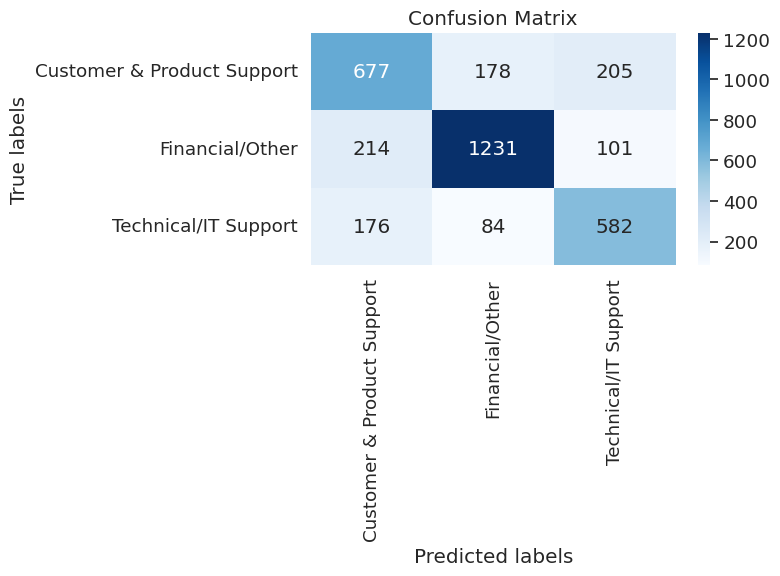

In [9]:
plot_confusion_matrix(y_true, y_pred, target_names=unique_labels)

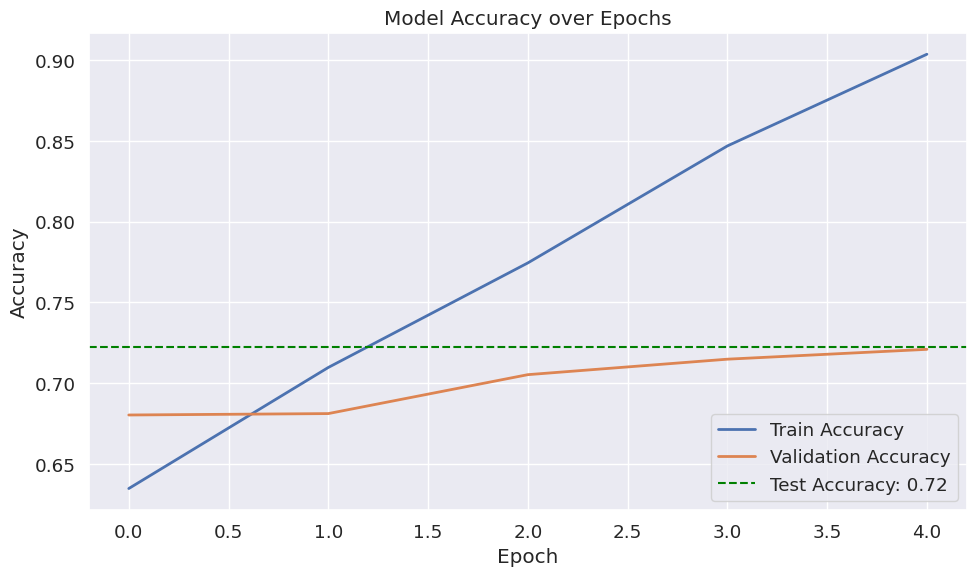

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)

epochs = len(history.history['accuracy'])
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In our experiments, although we extensively tuned the hyperparameters—adjusting the learning rate, dropout rate, and employing early stopping and learning rate scheduling—we observed a clear indication of overfitting. Despite achieving a relatively high training accuracy, the validation and test accuracies stabilized at only around 72%, with the model showing a loss of generalization. When we attempted to counteract overfitting by imposing stronger regularization techniques or reducing the model complexity, the solution failed to converge properly, resulting in much lower accuracy.

These results suggest a challenging trade-off: efforts to control overfitting often led to underfitting and insufficient convergence, while a relaxed setup brought out overfitting issues. Although DistilBERT was expected to perform well given its strong contextual representations, our findings indicate that its current configuration is not ideal for this specific classification task. The limited improvement in the balanced accuracy and the gap between training and validation performance demonstrate that, for our dataset and problem, the model overfits the training data without achieving the desired generalization. In summary, while the model is capable of learning the underlying patterns in the data, the high susceptibility to overfitting and the difficulty in finding a balanced compromise suggest that an alternative architecture or additional data augmentation methods may be more appropriate to address this task effectively.